# End-to-end ASR model training

This notebook will run through the process of training an automatic speech recognition (ASR) model using the PyTorch library. We'll train an LSTM network to recognize spoken English.

Our model will be trained on the [LibriSpeech](https://www.google.com/url?q=https%3A%2F%2Fwww.openslr.org%2F12) dataset. LibriSpeech is a corpus of approximately 1,000 hours of English speech derived from audiobooks in the LibriVox project, which features various audiobooks read out loud. The dataset includes corresponding transcripts, making it widely used for training and evaluating automatic speech recognition (ASR) systems, even today.

## Import libraries

Here, we load all the libraries that we'll use throughout the notebook. These include libraries for processing audio, visualizing data, and training neural networks.

In [2]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.1 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import pandas as pd
from jiwer import wer
from torchaudio.datasets import LIBRISPEECH
from torch.utils.data import DataLoader
from torchaudio.transforms import MelSpectrogram, Resample
import matplotlib.pyplot as plt
from IPython.display import Audio, display

## Data loading

First we download LibriSpeech from [here](https://www.google.com/url?q=https%3A%2F%2Fwww.openslr.org%2F12) and save it to `./data`.

In [4]:
!wget -P ./data https://openslr.magicdatatech.com/resources/12/dev-clean.tar.gz
!wget -P ./data https://openslr.magicdatatech.com/resources/12/test-clean.tar.gz
!tar -xzf ./data/dev-clean.tar.gz -C ./data/
!tar -xzf ./data/test-clean.tar.gz -C ./data/

--2025-05-04 05:21:22--  https://openslr.magicdatatech.com/resources/12/dev-clean.tar.gz
Resolving openslr.magicdatatech.com (openslr.magicdatatech.com)... 39.96.249.211
Connecting to openslr.magicdatatech.com (openslr.magicdatatech.com)|39.96.249.211|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://huggingface.co/datasets/k2-fsa/LibriSpeech/resolve/main/dev-clean.tar.gz?download=true [following]
--2025-05-04 05:21:23--  https://huggingface.co/datasets/k2-fsa/LibriSpeech/resolve/main/dev-clean.tar.gz?download=true
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.88, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/36/f7/36f72105f1f8c311d1e6445a39145e726fd8143b7e306001ae293bdb19942a3d/76f87d090650617fca0cac8f88b9416e0ebf80350acb97b343a85fa903728ab3?response-content-dispositio

Next, we load the data into memory.

In [5]:
# Path to training data
data_folder = "./data"

# Load datasets
train_dataset = LIBRISPEECH(root=data_folder, url="dev-clean", download=False)
test_dataset = LIBRISPEECH(root=data_folder, url="test-clean", download=False)

## Explore audio data
Before diving into training, let's visualize and listen to a few audio samples, to understand the data and ensure it was loaded correctly.

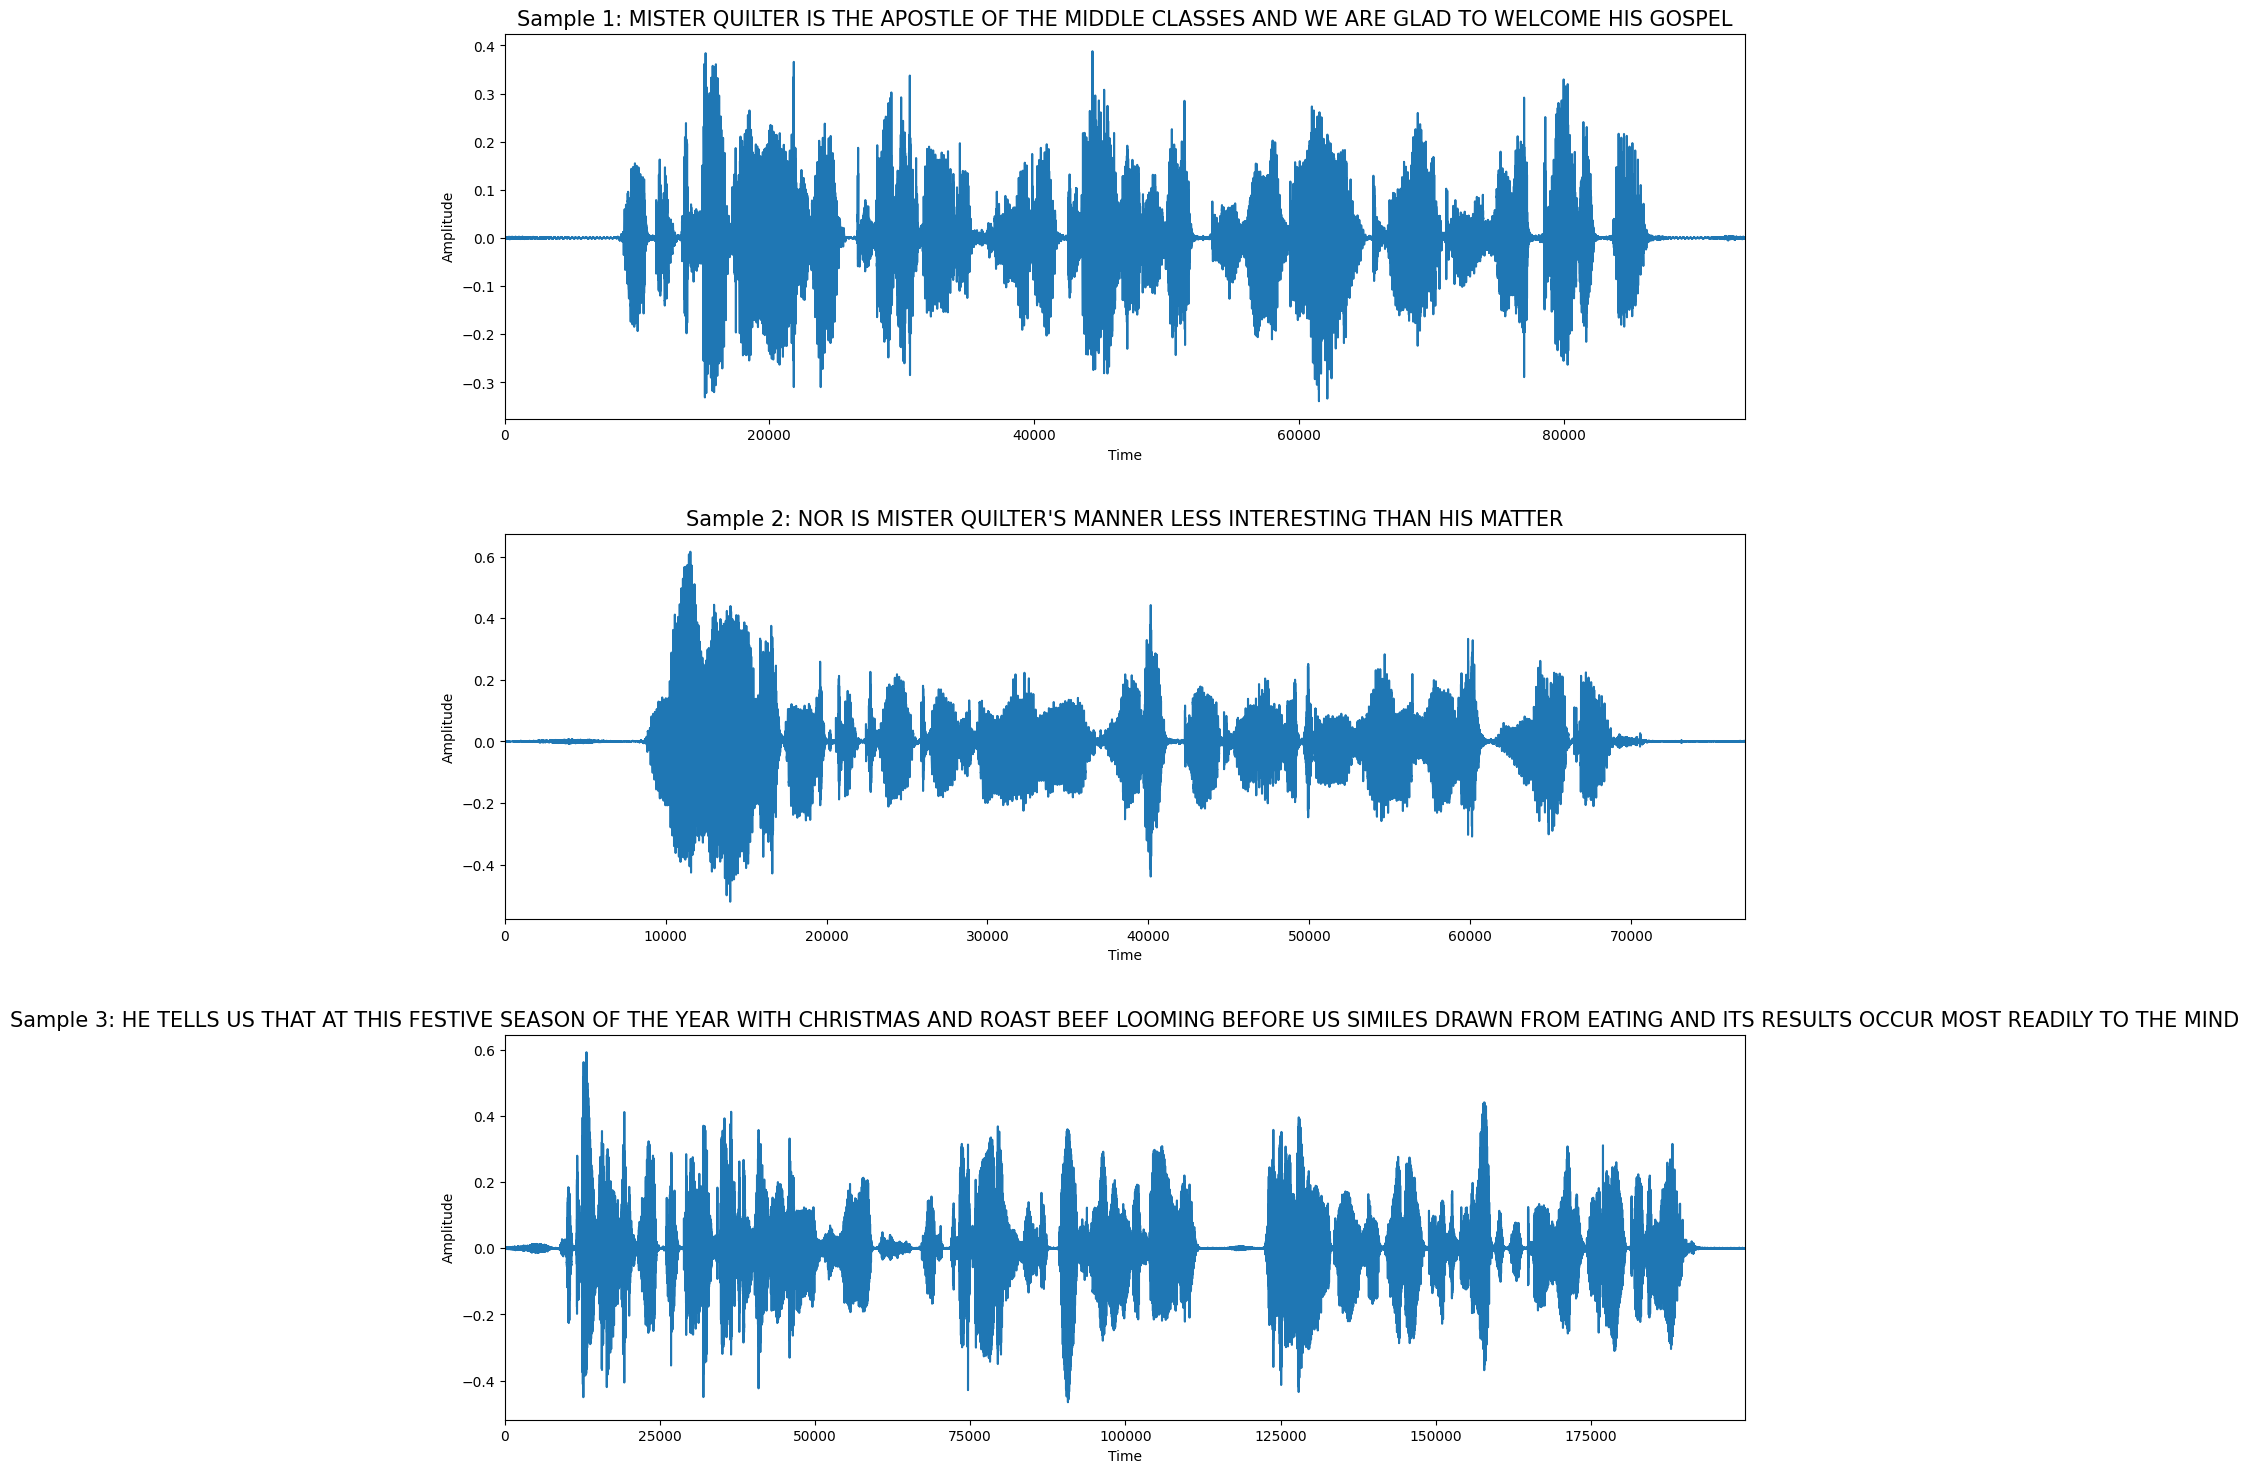

In [6]:
def plot_and_play_audio(samples=3):
    # Increase the figure size and the space between plots
    fig, axes = plt.subplots(nrows=samples, figsize=(16, 6 * samples))
    fig.subplots_adjust(hspace=0.3)  # Adjust vertical spacing between plots
    for i, (waveform, sample_rate, utterance, _, _, _) in enumerate(train_dataset):
        if i >= samples:
            break
        ax = axes[i] if samples > 1 else axes  # Adjust for case when samples is 1
        ax.plot(waveform.t().numpy())
        ax.set_title(f'Sample {i+1}: {utterance}', fontsize=15)  # Increase font size if necessary
        ax.set_xlim([0, waveform.shape[1]])
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
        display(Audio(waveform.numpy(), rate=sample_rate))

    plt.show()  # Ensure all plots are rendered

# Visualize and listen to a few samples from the dataset
plot_and_play_audio(samples=3)

Observe that LibriSpeech captions are all in uppercase with no punctuation, which simplifies preprocessing and model evaluation. Of course, real-world data isn't always this neat, and so newer datasets like [LibriSpeech-PC](https://arxiv.org/abs/2310.02943) include more complexities like punctuation and inconsistent capitalization.

Moreover, Librispeech is CLEAN data, so there is no need for noise removal

### Feature Extraction

Next, we are going to create mel spectrograms based off the audio data. Doing this step allows us to create more useful features for the model.

Let us plot some sample spectrograms and mel spectrograms based on the audio, and their corresponding waveforms.

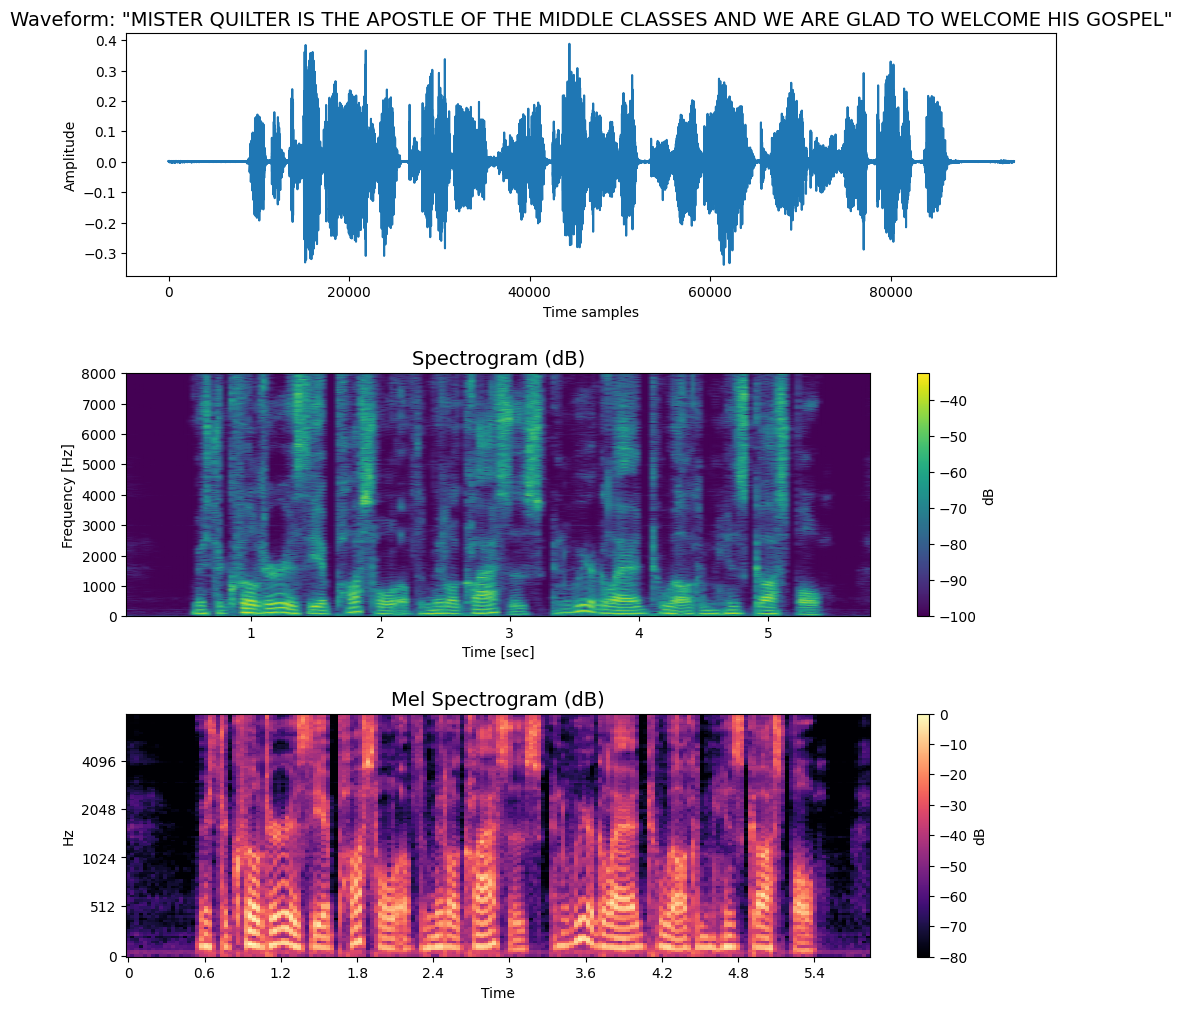

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import librosa
import librosa.display
from IPython.display import Audio, display

def plot_single_audio_example(dataset, index=0):
    # Pull one sample
    waveform, sample_rate, utterance, *rest = dataset[index]
    # Convert to numpy
    y = waveform.squeeze().numpy()

    # Compute spectrogram (STFT)
    f, t_spec, Sxx = spectrogram(y, fs=sample_rate, nperseg=1024, noverlap=512)
    Sxx_db = 10 * np.log10(Sxx + 1e-10)

    # Compute mel spectrogram
    S_mel = librosa.feature.melspectrogram(y=y, sr=sample_rate,
                                           n_fft=1024, hop_length=512, n_mels=128)
    S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

    # Create subplots: waveform, spectrogram, mel spectrogram
    fig, axes = plt.subplots(nrows=3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4)

    # Plot waveform
    axes[0].plot(y)
    axes[0].set_title(f'Waveform: "{utterance}"', fontsize=14)
    axes[0].set_xlabel('Time samples')
    axes[0].set_ylabel('Amplitude')

    # Plot classic spectrogram
    im1 = axes[1].pcolormesh(t_spec, f, Sxx_db, shading='gouraud')
    axes[1].set_title('Spectrogram (dB)', fontsize=14)
    axes[1].set_ylabel('Frequency [Hz]')
    axes[1].set_xlabel('Time [sec]')
    fig.colorbar(im1, ax=axes[1], label='dB')

    # Plot mel spectrogram
    img = librosa.display.specshow(S_mel_db,
                                   sr=sample_rate,
                                   hop_length=512,
                                   x_axis='time',
                                   y_axis='mel',
                                   ax=axes[2])
    axes[2].set_title('Mel Spectrogram (dB)', fontsize=14)
    fig.colorbar(img, ax=axes[2], label='dB')

    plt.show()

    # Play the audio
    display(Audio(y, rate=sample_rate))

# Example usage for the first sample
plot_single_audio_example(train_dataset, index=0)


### Collation
Collate function allows us to transform our batch of audio data into more useful features (eg. spectrograms)

In [8]:
resample_transform = Resample(orig_freq=16000, new_freq=16000)  # Define resample to standardize to 16 kHz

# Which device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def collate_fn(batch):
    tensors, targets, input_lengths, target_lengths, utterances = [], [], [], [], []
    for waveform, sample_rate, utterance, _, _, _ in batch:
        if sample_rate != 16000:
            waveform = resample_transform(waveform)  # Resample to 16 kHz if needed
        mel_spectrogram = MelSpectrogram()(waveform).squeeze(0).transpose(0, 1)
        tensors.append(mel_spectrogram)
        target = torch.tensor([ord(c) - ord('a') for c in utterance.lower() if c.isalpha()])
        targets.append(target)
        input_lengths.append(mel_spectrogram.shape[0])
        target_lengths.append(len(target))
        utterances.append(utterance)
    tensors = nn.utils.rnn.pad_sequence(tensors, batch_first=True).to(device)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True).to(device)
    input_lengths = torch.tensor(input_lengths).to(device)
    target_lengths = torch.tensor(target_lengths).to(device)
    return tensors, targets, input_lengths, target_lengths, utterances

train_loader = DataLoader(dataset=train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

### Tensor representation of audio signal

The first dimension of the audio tensor is the number of audio channels, while the second dimension is the number of samples.

In [9]:
waveform, sample_rate, _, _, _, _ = train_dataset[0]
if sample_rate != 16000:
    waveform = resample_transform(waveform)
print(f"Sample waveform tensor at 16kHz: {waveform}")
print(f'Tensor shape: {waveform.shape}')

Sample waveform tensor at 16kHz: tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]])
Tensor shape: torch.Size([1, 93680])


## Define model

We'll use a simple LSTM model.

In [10]:
class ASRModel(nn.Module):
    def __init__(self):
        super(ASRModel, self).__init__()
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 26)  # Assuming 26 letters in the alphabet

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)
        return output

model = ASRModel().to(device)

## Training with CTC loss

Below, we train the model with CTC loss and evaluate its performance on the test dataset.

We use word error rate (WER) as our evaluation metric. For now, you can think of WER as a way to quantify how far off our ASR model's output is from the actual transcript. (The specifics of WER calculation will be covered in a later module.)

In [11]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 16
max_steps_per_epoch = 10  # Limit the number of training steps
epochs = 5

# Loss and optimizer
criterion = nn.CTCLoss(blank=25, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to decode model output
def decode_output(output):
    output = output.transpose(0, 1)  # Make sure it is (batch, time, n_class)
    probabilities, max_indices = torch.max(output, 2)
    return ''.join([chr(i + ord('a')) for i in max_indices[0]])

# Training loop
model.train()
for epoch in range(5):
    for i, (inputs, targets, input_lengths, target_lengths, _) in enumerate(train_loader):
        if i >= max_steps_per_epoch:
            break
        optimizer.zero_grad()
        outputs = model(inputs)  # (batch, time, n_class)
        outputs = torch.nn.functional.log_softmax(outputs, dim=2)
        input_lengths = torch.clamp(input_lengths, max=outputs.shape[1])
        loss = criterion(outputs.permute(1, 0, 2), targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Testing loop
model.eval()
results = []
with torch.no_grad():
    for i, (inputs, _, _, _, utterances) in enumerate(test_loader):
        if i >= max_steps_per_epoch:
            break
        outputs = model(inputs)
        outputs = torch.nn.functional.log_softmax(outputs, dim=2)
        predictions = [decode_output(outputs[j].unsqueeze(0)) for j in range(outputs.shape[0])]

        for utterance, prediction in zip(utterances, predictions):
            error = wer(utterance, prediction)
            results.append({'Ground Truth': utterance, 'Prediction': prediction, 'WER': error})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())

print("Training and testing completed")

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/5], Step [10/169], Loss: 17.9075
Epoch [2/5], Step [10/169], Loss: 16.9206
Epoch [3/5], Step [10/169], Loss: 15.2537
Epoch [4/5], Step [10/169], Loss: 17.7640
Epoch [5/5], Step [10/169], Loss: 14.1700
                                        Ground Truth Prediction  WER
0  HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...          z  1.0
1         STUFF IT INTO YOU HIS BELLY COUNSELLED HIM          z  1.0
2  AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...          z  1.0
3                 HELLO BERTIE ANY GOOD IN YOUR MIND          z  1.0
4  NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...          z  1.0
Training and testing completed


## Training with cross-entropy loss

Now let's try using cross-entropy loss to train our model! Note that we'll have to modify our `collate_fn` to align inputs and targets.

In [12]:
def collate_fn(batch):
    tensors, targets, input_lengths, target_lengths, utterances = [], [], [], [], []

    for waveform, sample_rate, utterance, _, _, _ in batch:
        if sample_rate != 16000:
            waveform = resample_transform(waveform)
        mel_spectrogram = MelSpectrogram()(waveform).squeeze(0).transpose(0, 1)
        tensors.append(mel_spectrogram)

        # For CrossEntropy, we need target sequences aligned with input frames
        input_length = mel_spectrogram.shape[0]
        chars = [ord(c) - ord('a') for c in utterance.lower() if c.isalpha()]

        # Create a target sequence the same length as the input
        # This is very simplified - a real implementation would need proper alignment
        if len(chars) > 0:
            # Stretch or compress the target to match input length
            target = []
            for i in range(input_length):
                idx = min(int(i * len(chars) / input_length), len(chars) - 1)
                target.append(chars[idx])
            target = torch.tensor(target)
        else:
            target = torch.zeros(input_length, dtype=torch.long)

        targets.append(target)
        input_lengths.append(input_length)
        target_lengths.append(len(chars))  # Original length for reference
        utterances.append(utterance)

    # Pad sequences
    tensors = nn.utils.rnn.pad_sequence(tensors, batch_first=True).to(device)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=-100).to(device)
    input_lengths = torch.tensor(input_lengths).to(device)
    target_lengths = torch.tensor(target_lengths).to(device)
    return tensors, targets, input_lengths, target_lengths, utterances


train_loader = DataLoader(dataset=train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

### Decoding outputs

CE loss doesn't automatically decode model output into a form that can be matched against ground-truth text. This means that we'll have to remove repeated letters ourselves when decoding model output (i.e. converting it into text). Below is a decoder function that does just that. (For teaching purposes, we also provide a decoder that doesn't remove repeated letters.)

In [13]:
# Function to decode model output with CrossEntropy approach
def decode_output(output):
  '''
  Note: This is a naive way to decode outputs, and is one of the reasons why
  CTC loss was more popular traditionally. Not only is decoding outputs more
  complicated, but you also have issues here with repeated words

  Eg. hello collapses into helo due to the logic implemented here.

  With CTC, since we use a blank token to align, we dont have to worry about
  aligning the decoding.
  '''
    # Get the most likely class at each timestep
  _, predicted_indices = torch.max(output, dim=2)  # (batch, time)

  # Convert to characters and join
  batch_predictions = []
  for sequence in predicted_indices:
      # Remove repeated characters
      prev_char = None
      chars = []
      for idx in sequence:
          char = chr(idx.item() + ord('a'))
          if char != prev_char:  # Simple collapse of repeats
              chars.append(char)
              prev_char = char

      prediction = ''.join(chars)
      batch_predictions.append(prediction)

  return batch_predictions[0] if len(batch_predictions) == 1 else batch_predictions

## For comparison, we also added a decode_output without collapsing letters
def decode_output_without_collapsing(output):
    # Get the most likely class at each timestep
    _, predicted_indices = torch.max(output, dim=2)  # (batch, time)

    # Convert to characters and join
    batch_predictions = []
    for sequence in predicted_indices:
        chars = []
        for idx in sequence:
            char = chr(idx.item() + ord('a'))
            chars.append(char)

        prediction = ''.join(chars)
        batch_predictions.append(prediction)

    return batch_predictions[0] if len(batch_predictions) == 1 else batch_predictions

### Training code

Here are sample training and testing loops, to demonstrate some of the outputs. Observe that most of the training code is similar to that for CTC loss. PyTorch makes it easy for us - once preprocessing and decoding are settled, our training code can be preserved!

In [14]:
# Hyperparameters
learning_rate = 0.0001
max_steps_per_epoch = 10
batch_size = 16
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Use -100 as padding index
epochs = 5

# Loss and optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


# Training loop for CrossEntropy
model.train()
for epoch in range(5):
    for i, (inputs, targets, input_lengths, target_lengths, _) in enumerate(train_loader):
        if i >= max_steps_per_epoch:
            break

        optimizer.zero_grad()
        outputs = model(inputs)  # (batch, time, n_class)

        # Reshape for CrossEntropyLoss: (N*L, C)
        batch_size, seq_len, num_classes = outputs.size()
        outputs_flat = outputs.view(-1, num_classes)
        targets_flat = targets.view(-1)

        # Calculate loss only on non-padding positions
        loss = criterion(outputs_flat, targets_flat)

        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


# Testing loop
model.eval()
results = []
with torch.no_grad():
    for i, (inputs, _, _, _, utterances) in enumerate(test_loader):
        if i >= max_steps_per_epoch:
            break

        outputs = model(inputs)
        predictions = decode_output(outputs)
        raw_predictions = decode_output_without_collapsing(outputs)

        if not isinstance(predictions, list):
            predictions = [predictions]

        if not isinstance(raw_predictions, list):
            raw_predictions = [raw_predictions]

        for utterance, prediction, raw_prediction in zip(utterances, predictions, raw_predictions):
            error = wer(utterance, prediction)
            results.append({'Ground Truth': utterance, "Raw Prediction":raw_prediction, 'Prediction': prediction, 'WER': error})


#Print Results
results_df = pd.DataFrame(results)
print(results_df.head())

print("Training and testing completed")

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/5], Step [10/169], Loss: 3.2737
Epoch [2/5], Step [10/169], Loss: 3.2557
Epoch [3/5], Step [10/169], Loss: 3.2257
Epoch [4/5], Step [10/169], Loss: 3.2163
Epoch [5/5], Step [10/169], Loss: 3.1900
                                        Ground Truth  \
0  HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...   
1         STUFF IT INTO YOU HIS BELLY COUNSELLED HIM   
2  AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...   
3                 HELLO BERTIE ANY GOOD IN YOUR MIND   
4  NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...   

                                      Raw Prediction  \
0  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...   
1  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzezzzzzzzzzzz...   
2  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...   
3  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzleeeeez...   
4  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzeeeeeezzzzzee...   

                                          Prediction  WER  
0  zszeaeaezezezezaezezezazaezezezezezeziezezezez...  1.0  
1